# Projekt zaliczeniowy - Reprezentacja i przetwarzanie obrazu

### Skład zespołu:

- Julia May 150653
- Patryk Jedlikowski 136723
- Mikołaj Sienkiewicz 136309

### Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv2

### Uploading input data

In [2]:
files = glob.glob("./cathedral/*.jpg")

In [3]:
images = []
for file in files:
    images.append(np.array(Image.open(file)))

Poniższy raport składa się z dwóch części:
- W pierwszej części (nazwanej "Testing different approaches") zaprezentowane zostały różne operacje na obrazie, które przetestowaliśmy starając się uchwycić sylwetki przechodniów możliwie najlepiej co w efekcie pozwoliłoby je wyekstrachować w ostatecznym rozwiązaniu. 

- W drugiej części nazwanej "Solution" najbardziej obiecujące eksperymenty i metody z pierwszej części zostały złożone w jedno rozwiązanie prezentujące wynikowe zdjęcie

W miejscach mogących wymagać dodatkowego objaśnienia umieściliśmy, krótkie opisy tłumaczące jaki był zamysł poszczególnych operacji.

# Testing different approaches 

#### Subtraction and thresholding

Krótki test uświadamiający, że zdjęcia zawsze są trochę przesuniete względem siebie więc nie wystarczy odjąć jedno od drugiego, żeby wykryć różniące te zdjęcia elementy (w naszym przypadku sylwetki). Widać tutaj, że pomimo, iż oczekiwalibyśmy, że piksele na fasadzie katedry (która "na oko" na wszystkich zdjęciach wydaje się być w takiej samej orientacji) po odjęciu od siebie obu zdjęć przyjmą wartość 0, widzimy jednak, że tak nie jest.

In [4]:
x = (images[0] - images[1])
x[x>=200] = 255
x[x<200] = 0

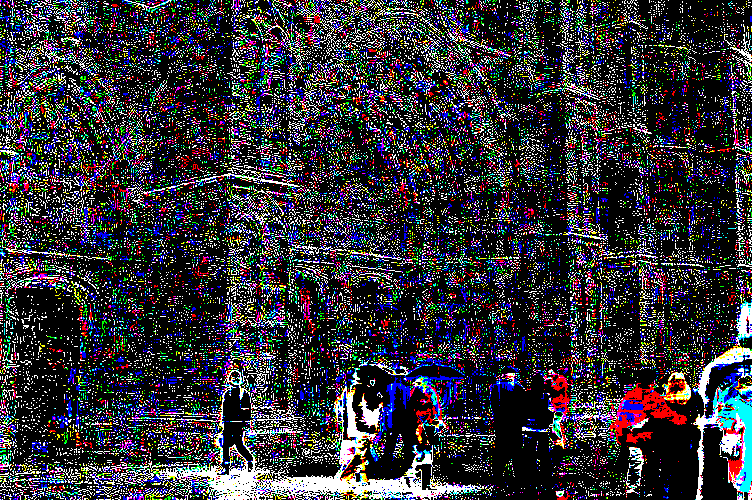

In [5]:
Image.fromarray(x)

#### Taking mean value

Test sprawdzający w których miejscach i z jaką intensywnością sylwetki pojawiły się na zdjęciach. Podejście to wykorzystuje wyliczenie wartości średniej dla każdego piksela po wszystkich obrazach.

In [6]:
images = np.array(images)

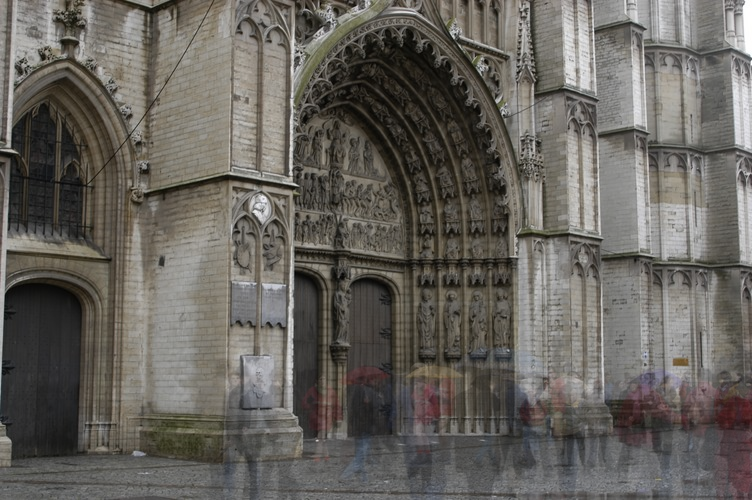

In [7]:
Image.fromarray(np.mean(images, axis=0).astype('uint8'))

#### Taking median value

Próba wycięcia sylwetek biorąc medianę ze wszystkich kanałów na raz. Widzimy jednak tutaj, że w niektórych częściach obrazu po zastosowaniu mediany nadal widoczne są kolory, pochodzące z sylwetek postaci.

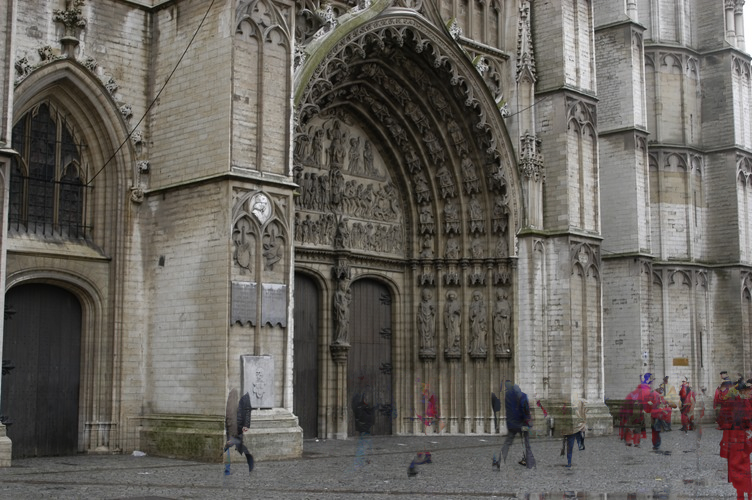

In [8]:
Image.fromarray(np.median(images, axis=0).astype('uint8'))

####  Thresholding on seperate RGB Channels

Wykrywanie sylwetek biorąc pod uwagę ich charakterystykę na zdjęciu. To znaczy analizując histogram fotografii możemy z całkiem dużą pewnością wyciągnąć wniosek, że stosunkowo monochromatyczny budynek powinniśmy być w stanie odseparować od barwnych kurtek wykorzystując jakieś progowanie na poszczególnych kanałach. 

Na przykład czerwona kurtka będzie miała wyraźnie wyższe wartości w czerwonym kanale piksela co powinniśmy być w stanie wykryć warunkiem w masce i na przykład zamalowując to miejsce na czarno.

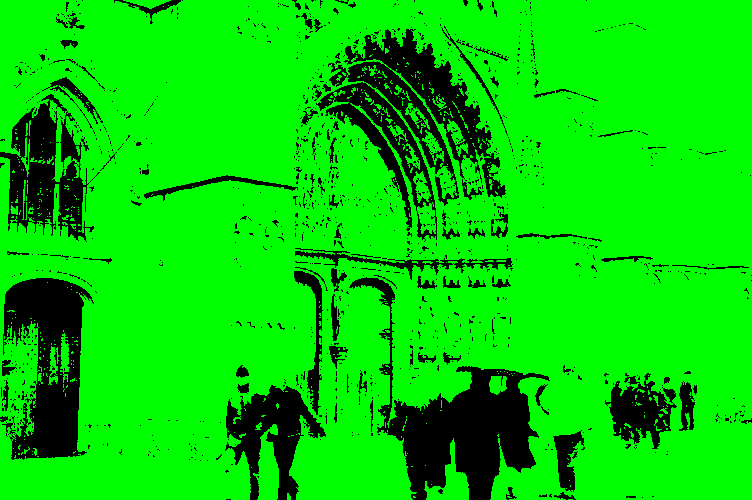

In [9]:
b = images[4].copy()

# set blue and red channels to 0
b[:, :, 0] = 0
b[:, :, 2] = 0

N = 50
b[b>=N] = 255
b[b<N] = 0
Image.fromarray(b)

#### Eroding masked image to fill out gaps in detected silhouettes

Użycie morfologii zdjęć (dokładniej erozji) w celu wypełnienia wykrytych przestrzeni na zdjęciu nie spełniających warunku zadanego w masce. Operacja ta umożliwia nam wypełnienie przestrzeni na przykład pomiędzy rękami postaci a ich tułowiem. 

In [10]:
struct = np.ones((3, 3),np.uint8)

In [11]:
eroded = cv2.erode(b, struct, iterations=2)

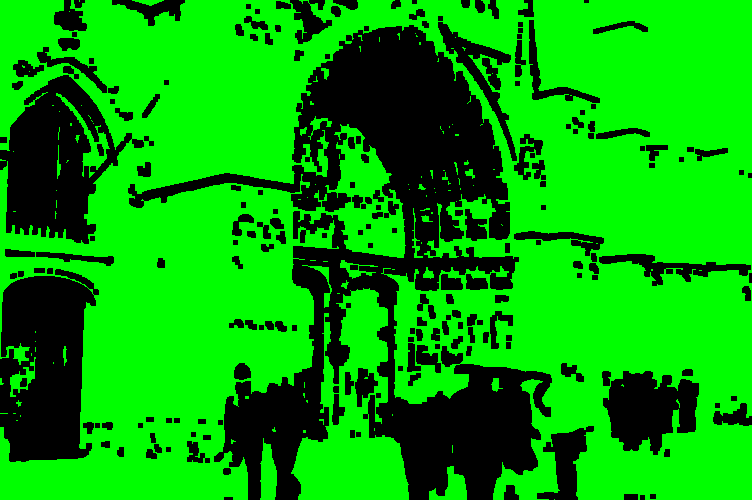

In [12]:
Image.fromarray(eroded)

In [13]:
eroded[eroded==255] = 1

In [14]:
img = eroded[..., 1] * images[0][..., 1]

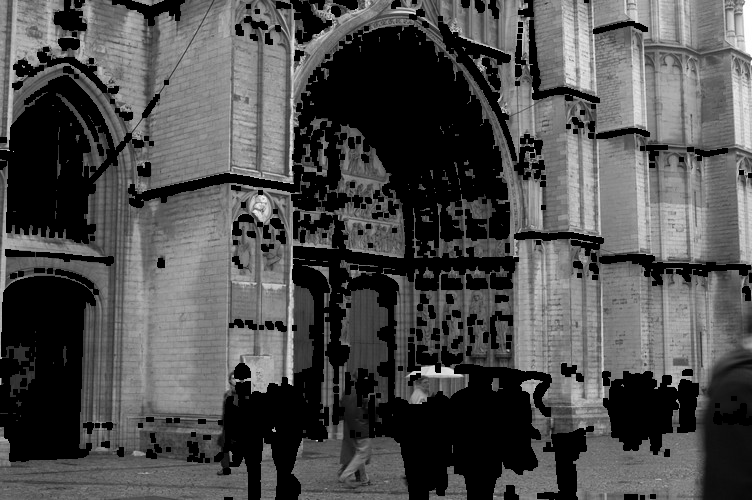

In [15]:
Image.fromarray(img)

Możemy zauważyc, że to podejście stosunkowo dobrze poradziło sobie z wyznaczeniem miejsc zawierających sylwetki biorąc pod uwagę, że są to jedynie operacje wektorowe na obrazie (np.array). 

Niestety poza sylwetkami zostały wycięte również elementy budynku, które załapały się w masce mimo że nie powinny. Z tego względu w poniższym rozwiązaniu na samym dole jest linijka 

```python
filteredImage[filteredImage==0] = np.max(images, axis=0).astype('uint8')[filteredImage==0]
```

która wszystkie luki których nie udało nam sie uzupełnić (bo zostały wycięte wszędzie), uzupełnimy najjaśniejszą wartością z otrzymanych zdjęć.


# SOLUTION

Ostateczne rozwiązanie wykorzystuje dla każdego dostępnego obrazu iterację po wszystkich trzech jego kanałach, za każdym razem dwa z nich są wyzerowane, przez co możemy obserwować strukturę obrazu oddzielnie na kanałach R, G i B. Na każdym z nich wykorzystujemy próg wartości piksela równy 50, wszystkie piksele o większej wartości otrzymują największą intensywność koloru (255), wszystkie o mniejszej wartości - wartość minimalną (0). 

Następnie na każdym kanale wykorzystujemy erozję z maską jedynek o wymiarze (3, 3), w celu wypełnienia przestrzeni między wykrytymi na tym kanale obiektami (dzięki temu wypełniamy na przykład przestrzenie między rękami postaci). 

W kolejnym kroku ustawiamy na wartość 1 te piksele, które przyjmują wartość maksymalną (te chcemy zachować, pozostałe przyjmują wartość 0) i obraz ten wykorzystujemy w charakterze maski, mnożąc go przez odpowiedni kanał obrazu wyjściwego, aby usunąć odpowiednie piksele, na których znajdują się postacie. 

Po zakończeniu iteracji dla wszystkich obrazów bierzemy medianę po wszystkich z nich, żeby uzupełnić usunięte piksele i na koniec miejsca z pikselami, których nie udało się w ten sposób uzupełnić wypełniamy maksymalnymi wartościami danych pikseli ze wszystkich nieprzetworzonych obrazów.

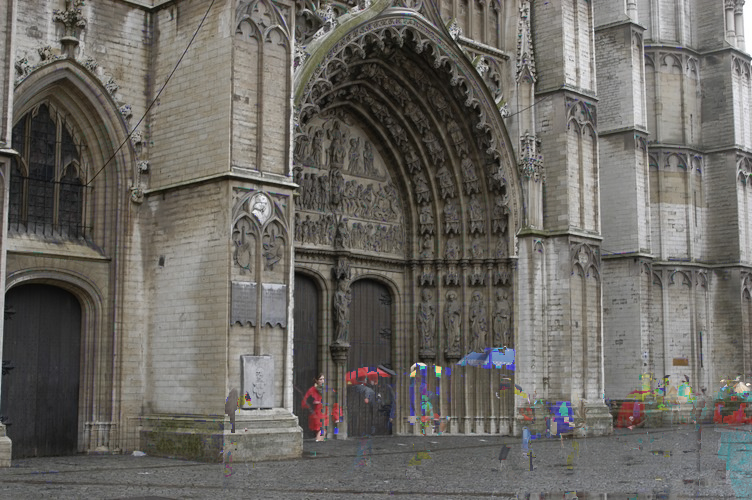

In [16]:
N = 50
struct = np.ones((3, 3),np.uint8)

filteredImage = np.zeros(images.shape)

for i in range(5):
    for channel in [0,1,2]:
        b = images[i].copy()
        # set two of three channels to 0
        if channel == 0:
            b[:, :, 1] = 0
            b[:, :, 2] = 0
        if channel == 1:
            b[:, :, 0] = 0
            b[:, :, 2] = 0
        if channel == 2:
            b[:, :, 0] = 0
            b[:, :, 1] = 0
        
        # set mask
        b[b>=N] = 255
        b[b<N] = 0
        
        # erode
        eroded = cv2.erode(b, struct, iterations=2)
        eroded[eroded==255] = 1
        filteredImage[i][..., channel] = eroded[..., channel] * images[i][..., channel]
filteredImage = filteredImage.astype('uint8')
filteredImage = np.median(filteredImage, axis=0).astype('uint8')
# fill empty pixels
filteredImage[filteredImage==0] = np.max(images, axis=0).astype('uint8')[filteredImage==0]

# show image
Image.fromarray(filteredImage)